# Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt

# Data exploration & preprocessing

## Load data

In [2]:
# Load data
x_train = pd.read_csv("../raw_data/X_train_v2.csv", index_col=0)
x_test = pd.read_csv("../raw_data/X_test_v2.csv", index_col=0)
y_train = pd.read_csv("../raw_data/Y_train_sl9m6Jh.csv", index_col=0)

# Concatenate x_rtain and x_test for exploration
df = pd.concat([x_train, x_test])

# Define Time column as datetime
df.loc[:, 'Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M')
df.loc[:, 'WF'] = df["WF"].apply(lambda x: int(x.strip('WF')))

# Add y_train in a column named Production
df.loc[y_train.index, 'Production'] = y_train

In [3]:
df.loc[51:54]

,WF,Time,NWP1_00h_D-2_U,NWP1_00h_D-2_V,NWP1_00h_D-2_T,NWP1_06h_D-2_U,NWP1_06h_D-2_V,NWP1_06h_D-2_T,NWP1_12h_D-2_U,NWP1_12h_D-2_V,...,NWP4_12h_D-1_U,NWP4_12h_D-1_V,NWP4_12h_D-1_CLCT,NWP4_00h_D_U,NWP4_00h_D_V,NWP4_00h_D_CLCT,NWP4_12h_D_U,NWP4_12h_D_V,NWP4_12h_D_CLCT,Production
ID,,,,,,,,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,4.4229,-16.527,288.68,6.3428,-16.317,288.57,2.8521,-15.495,...,4.295196,-7.850803,-0.000016,4.450514,-6.487014,-0.000013,NaN,NaN,NaN,5.39
52,1,2018-05-03 04:00:00,5.0740,-16.985,288.40,6.7567,-16.895,288.23,2.7426,-16.285,...,4.295196,-8.693379,-0.000016,4.369153,-7.600720,-0.000013,NaN,NaN,NaN,5.11
53,1,2018-05-03 05:00:00,5.8899,-17.983,288.21,6.8435,-17.223,287.99,3.0243,-17.227,...,4.292873,-8.995411,-0.000016,3.888633,-8.621414,-0.000013,NaN,NaN,NaN,5.03
54,1,2018-05-03 06:00:00,6.1131,-18.897,287.97,7.1638,-17.580,287.95,3.4257,-17.655,...,4.220859,-9.930776,-0.000016,3.100145,-9.882844,0.035084,NaN,NaN,NaN,7.18


_Meteorological variables_: Numerical Weather Predictions are provided by meteorological centers several times a day (updates), typically at 00h UTC, 06h UTC, 12h UTC and 18h UTC. We call these sets of forecasts "Runs". Consequently, if the input file contains forecasts arising from several runs, this implies that a single NWP is associated with several forecasts for the same forecasting time

The format of the header of the csv files for the meteorological variables is the following:
*NWPi_HourOfTheRun_DayOfTheRun_Variable*

With:
- _NWPi_ the considered Numerical Weather Prediction model (meteorological model);
- _HourOfTheRun_ the hour (UTC) of the considered run. According to the NWP, it could be 00h, 06h, 12h and 18h (case of NWP with 4 runs per day) or only 00h and 12h (case of NWP with 2 runs per day);
- _DayOfTheRun_ the day of the considered run. We provide in the csv files predictions from the D-2 day runs (the day before yesterday), D-1 day runs (yesterday) and D day runs;
- _Variables_ the different meteorological variables forecasted by the NWP. These are essentially U, V and T:

 - _U and V components_ of the wind at 100m (or 10m) height (m/s): these are the zonal and meridional velocities of the wind, respectively. Both are given at a height of 100m above ground for NWP1, NWP2 and NWP3. U and V are given at a height of 10m for NWP4. Even if these variables are given at hourly timestep, **the temporal representativity of the given values is for a 10-minutes window ranging from H-10 min to H**
  - _Temperature of air (°C), abbreviated T_: this is the averaged temperature over the entire hour (from H-1 to H). Wind power production is sensitive to air temperature since it affects the air density. **This variable is provided only for NWP1 and NWP3**
  - _Total cloud cover (%), abbreviated CLCT_: this is the total cloud cover of the sky, ranging from 0% (clear sky, no cloud) to 100% (fully clouded sky). **The value is an instant value at hour H. This variable is provided only for NWP4.**

NWP Variable | Timeframe | NWP 1 (hourly) | NWP 2 (every 3 hours) | NWP 3 (every 3 hours) | NWP 4 (hourly)
------ | ----- | ----- | ----- | ----- | ----- 
Wind speed U,V (m/s) | 10 min average [H-10min,H] | x (@100m) | x (@100m) | x (@100m) | x (@10m) 
Temperature of air T (m/s) | 1 hour average [H-1,H] | x | | x | 
Total cloud cover CLCT (%) | instant value at H | | | | x

In [81]:
# Number of periods par Wind Farm in training and test datasets respectively
df.assign(
    training = df.Production.isna(), 
    test = ~df.Production.isna())\
    [['WF','training','test']]\
    .groupby("WF").sum()

,training,test
WF,,
1,6190,6239
2,6190,6239
3,6190,6239
4,6190,6239
5,5579,6180
6,6190,6239


## Preprocessing

### Calculate best forecasts

For a given target time, a NWP model is forecasting a weather variable several times (at different delays before the target time).

In [5]:
df.loc[51:56,['WF','Time']+[col for col in df.columns if col.startswith('NWP4') and col.endswith('_U')]]

,WF,Time,NWP4_00h_D-2_U,NWP4_12h_D-2_U,NWP4_00h_D-1_U,NWP4_12h_D-1_U,NWP4_00h_D_U,NWP4_12h_D_U
ID,,,,,,,,
51,1,2018-05-03 03:00:00,NaN,5.144098,4.668093,4.295196,4.450514,NaN
52,1,2018-05-03 04:00:00,NaN,4.850463,4.863529,4.295196,4.369153,NaN
53,1,2018-05-03 05:00:00,NaN,4.834910,4.863529,4.292873,3.888633,NaN
54,1,2018-05-03 06:00:00,NaN,4.677517,4.659237,4.220859,3.100145,NaN
55,1,2018-05-03 07:00:00,NaN,4.286832,4.404757,3.591898,2.557376,NaN
56,1,2018-05-03 08:00:00,NaN,3.910456,4.382320,3.244605,1.746500,NaN


Best forecasts by NWP will be computed using a weighted mean of the forecasts with a memory coefficient as hyperparameter

In [6]:
def get_run_infos(run_name):
    """ Returns predictor name and timedelta from run name"""
    predictor = '_'.join(run_name.split('_')[::3])
    run_day_offset_str = run_name.split('_')[2].strip('D')
    run_day_offset = int(run_day_offset_str) if run_day_offset_str != '' else 0
    run_time = int(run_name.split('_')[1].strip('h'))
    timedelta = dt.timedelta(days=run_day_offset, hours=run_time)
    return predictor, timedelta

In [7]:
def reshape_run_data(run_data):
    """ Returns run data in a dataframe with predictor name, delay and value columns """
    # Preparation
    run_name = [col for col in run_data.columns if col.startswith('NWP')][0]

    # Computing predictor and delay
    predictor, timedelta = get_run_infos(run_name)
    run_data.loc[:, 'predictor'] = predictor
    update_time = run_data.Time.dt.normalize() + timedelta
    run_data.loc[:, 'delay'] = (run_data.Time - update_time) / pd.Timedelta('1h')
    
    # Cleaning
    run_data.rename(columns={run_name: 'value'}, inplace=True)
    run_data.drop(columns='Time', inplace=True)
    run_data.dropna(subset=['value'], inplace=True)
    run_data.reset_index(inplace=True)
    return run_data

In [8]:
# Reshape and concatenate each NWP_run data ( index=[ID,predictor]] , columns=[delay,value] )
best_forecasts = pd.concat([reshape_run_data(df.loc[:, ['Time', col]])
                            for col in df.columns if col.startswith('NWP')], ignore_index=True)

In [9]:
best_forecasts.head()

,ID,value,predictor,delay
0,48,5.4041,NWP1_U,48.0
1,49,4.8424,NWP1_U,49.0
2,50,4.4050,NWP1_U,50.0
3,51,4.4229,NWP1_U,51.0
4,52,5.0740,NWP1_U,52.0


In [10]:
# Computing weight and weighted_value
forecast_memory = 0.2
best_forecasts.loc[:, 'weight'] = forecast_memory ** best_forecasts.delay
best_forecasts.loc[:, 'weighted_value'] = best_forecasts.weight * best_forecasts.value
best_forecasts

# Computing best forecasts
gb = best_forecasts.groupby(['ID', 'predictor'])
best_forecasts = gb.weighted_value.sum() / gb.weight.sum()
best_forecasts = best_forecasts.unstack(level=-1)

# Replace initial NWP runs forecasts by the best computed forecasts
not_nwp_cols = [col for col in df.columns if not col.startswith('NWP')]
df_best = pd.concat([df[not_nwp_cols], best_forecasts], axis=1)
df_best.head()

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,NWP4_CLCT,NWP4_U,NWP4_V
ID,,,,,,,,,,,,,,
1,1,2018-05-01 01:00:00,0.02,286.44,-2.2485,-3.2578,NaN,NaN,NaN,NaN,NaN,82.543144,1.254603,-0.289687
2,1,2018-05-01 02:00:00,0.07,286.26,-2.4345,-1.4461,NaN,NaN,NaN,NaN,NaN,99.990844,2.490908,-0.413370
3,1,2018-05-01 03:00:00,0.22,285.75,3.3659,-3.0605,2.6117,-2.3427,286.0,-1.148993,-2.274699,98.367235,0.997093,-1.415138
4,1,2018-05-01 04:00:00,0.39,284.78,3.7065,-6.2174,NaN,NaN,NaN,NaN,NaN,94.860604,0.689598,-0.961441
5,1,2018-05-01 05:00:00,0.41,284.46,3.8134,-5.4446,NaN,NaN,NaN,NaN,NaN,95.905879,0.290994,-0.294963


### Dealing with missing values

Missing values are interpolated linearly

In [11]:
def interpolate_nans(df):
    """ Interpolate missing values within each Wind farms """
    nwp_cols = [col for col in df.columns if col.startswith('NWP')]
    gb = df.groupby('WF')[nwp_cols]
    df.loc[:, nwp_cols] = gb.apply(lambda group: group.interpolate(method='linear', limit_direction='both'))
    return df

In [12]:
df_interp = interpolate_nans(df_best)
df_interp.head()

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,NWP3_V,NWP4_CLCT,NWP4_U,NWP4_V
ID,,,,,,,,,,,,,,
1,1,2018-05-01 01:00:00,0.02,286.44,-2.2485,-3.2578,2.6117,-2.3427,286.000000,-1.148993,-2.274699,82.543144,1.254603,-0.289687
2,1,2018-05-01 02:00:00,0.07,286.26,-2.4345,-1.4461,2.6117,-2.3427,286.000000,-1.148993,-2.274699,99.990844,2.490908,-0.413370
3,1,2018-05-01 03:00:00,0.22,285.75,3.3659,-3.0605,2.6117,-2.3427,286.000000,-1.148993,-2.274699,98.367235,0.997093,-1.415138
4,1,2018-05-01 04:00:00,0.39,284.78,3.7065,-6.2174,3.1783,-2.7838,285.666667,-0.518988,-2.721028,94.860604,0.689598,-0.961441
5,1,2018-05-01 05:00:00,0.41,284.46,3.8134,-5.4446,3.7449,-3.2249,285.333333,0.111017,-3.167357,95.905879,0.290994,-0.294963


### Feature engineering

Calculation of the Wind speed and the Wind direction

In [13]:
def append_features(df):
    """ Append wind speed and wind direction features in the dataframe"""
    nwp_cols = [col for col in df.columns if col.startswith('NWP')]
    for nwp_num in set([col.split('_')[0] for col in nwp_cols]):
        # Wind speed computation
        df.loc[:, nwp_num + '_WS'] = np.sqrt(df[nwp_num + '_U'] ** 2 + df[nwp_num + '_V'] ** 2)
        # Wind direction computation (angle)
        df.loc[:, nwp_num + '_WD'] = np.arctan2(df[nwp_num + '_U'], df[nwp_num + '_V'])  
    return df

In [14]:
df_aug = append_features(df_interp)
df_aug.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,...,NWP4_U,NWP4_V,NWP4_WS,NWP4_WD,NWP2_WS,NWP2_WD,NWP1_WS,NWP1_WD,NWP3_WS,NWP3_WD
ID,,,,,,,,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,288.350006,6.003520,-16.303010,4.850700,-12.651,286.299999,4.996607,...,4.450514,-6.487014,7.866920,2.540280,13.549062,2.775457,17.373267,2.788756,15.467656,2.812657
52,1,2018-05-03 04:00:00,5.11,288.120003,4.681039,-16.987960,4.440433,-13.064,286.199999,4.192226,...,4.369153,-7.600720,8.767009,2.619883,13.798027,2.813945,17.621093,2.872715,14.894384,2.856274
53,1,2018-05-03 05:00:00,5.03,287.710004,3.274157,-17.570962,4.030167,-13.477,286.100000,3.387845,...,3.888633,-8.621414,9.457815,2.717871,14.066690,2.851017,17.873410,2.957366,14.351678,2.903284
54,1,2018-05-03 06:00:00,7.18,287.519999,2.859262,-17.108018,3.619900,-13.890,286.000000,2.583464,...,3.100145,-9.882844,10.357679,2.837624,14.353946,2.886651,17.345306,2.975993,13.843133,2.953868


## Exploring data

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73904 entries, 1 to 73904
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   WF          73904 non-null  int64         
 1   Time        73904 non-null  datetime64[ns]
 2   Production  37375 non-null  float64       
 3   NWP1_T      73904 non-null  float64       
 4   NWP1_U      73904 non-null  float64       
 5   NWP1_V      73904 non-null  float64       
 6   NWP2_U      73904 non-null  float64       
 7   NWP2_V      73904 non-null  float64       
 8   NWP3_T      73904 non-null  float64       
 9   NWP3_U      73904 non-null  float64       
 10  NWP3_V      73904 non-null  float64       
 11  NWP4_CLCT   73904 non-null  float64       
 12  NWP4_U      73904 non-null  float64       
 13  NWP4_V      73904 non-null  float64       
 14  NWP4_WS     73904 non-null  float64       
 15  NWP4_WD     73904 non-null  float64       
 16  NWP2_WS     73904 non-

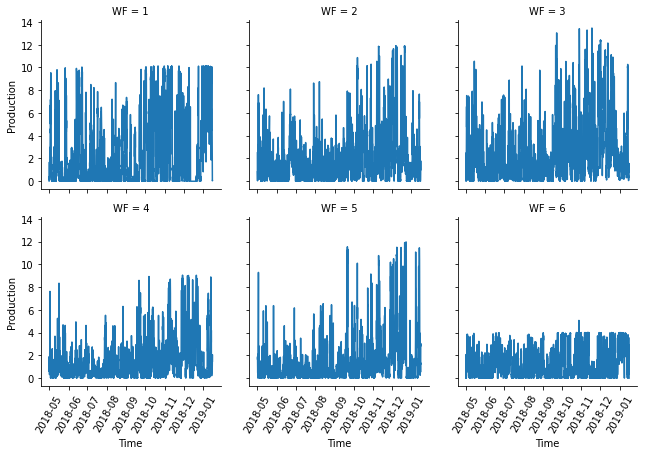

In [55]:
grid = sns.FacetGrid(df_aug, col="WF", col_wrap=3)
grid.map(sns.lineplot, 'Time','Production')

# Rotate x labels
for axes in grid.axes.flat:
    plt.setp(axes.xaxis.get_majorticklabels(), rotation=60)

grid.add_legend()
plt.show()

We can see that for instance that the maximal power production authorized is reached in WF1 and WF6, and that this limit is different from a wind farm to another (limited at 10 MW for WF1 and at 4 MW for WF6).

In [18]:
nwp_var = 'T'
nwp_runs = [col for col in df_aug.columns if col.startswith('NWP') and col.split('_')[1] == nwp_var]
nwp_runs

['NWP1_T', 'NWP3_T']

In [17]:
def separate_feature_info(df, run, with_prod=False):
    """ Separate run data (Time, WF, run_value) into (Time, WF, nwp_num, run_value) """   
    nwp_num = int(run.split('_')[0].strip('NWP'))
    nwp_var = run.split('_')[1]
    base_columns = ["Time", "WF", run]
    if with_prod is True:
        base_columns.append("Production")
    return df[base_columns].assign(NWP=nwp_num) \
        .rename(columns={run: nwp_var})

In [19]:
df_plot = pd.concat([separate_feature_info(df_aug, run, with_prod=True) for run in nwp_runs]).sort_values(by='Time')
df_plot.head()

,Time,WF,T,Production,NWP
ID,,,,,
1,2018-05-01 01:00:00,1,286.440000,0.02,1
6240,2018-05-01 01:00:00,2,279.150000,0.83,1
12479,2018-05-01 01:00:00,3,276.000064,1.49,3
12479,2018-05-01 01:00:00,3,275.690000,1.49,1
6240,2018-05-01 01:00:00,2,279.000000,0.83,3


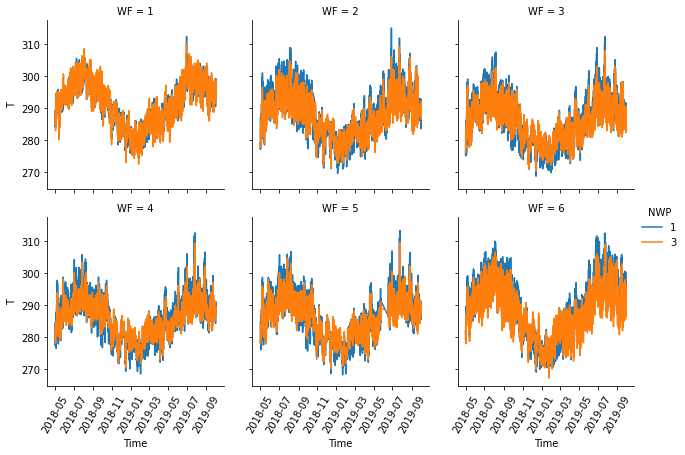

In [26]:
grid = sns.FacetGrid(df_plot, col="WF", hue="NWP", col_wrap=3)
grid.map(sns.lineplot, 'Time','T')

# Rotate x labels
for axes in grid.axes.flat:
    plt.setp(axes.xaxis.get_majorticklabels(), rotation=60)

grid.add_legend()
plt.show()

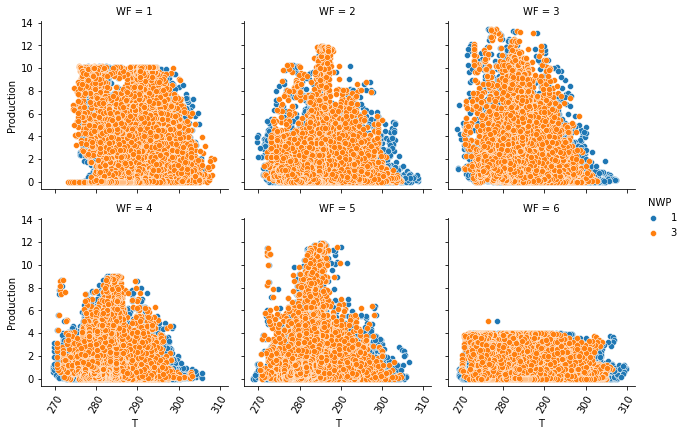

In [27]:
grid = sns.FacetGrid(df_plot, col="WF", hue="NWP", col_wrap=3)
grid.map(sns.scatterplot, 'T','Production')
# Rotate x labels
for axes in grid.axes.flat:
    plt.setp(axes.xaxis.get_majorticklabels(), rotation=60)
grid.add_legend()
plt.show()

In [30]:
# Compute the mean value for each weather variable across the NWP models
nwp_cols = [col for col in df_aug.columns if col.startswith('NWP')]
df_mean = df_aug.drop(columns=nwp_cols)
for nwp_var in set([col.split('_')[1] for col in nwp_cols]):
    predictors = [col for col in nwp_cols if col.split('_')[1] == nwp_var]
    df_mean.loc[:, nwp_var] = df_aug[predictors].mean(axis=1)
df_mean.head()

,WF,Time,Production,U,V,CLCT,WS,WD,T
ID,,,,,,,,,
1,1,2018-05-01 01:00:00,0.02,0.117203,-2.041222,82.543144,2.825723,-0.277917,286.220000
2,1,2018-05-01 02:00:00,0.07,0.379779,-1.619217,99.990844,2.853363,-0.185863,286.130000
3,1,2018-05-01 03:00:00,0.22,1.456425,-2.273259,98.367235,3.084319,1.116149,285.875000
4,1,2018-05-01 04:00:00,0.39,1.763852,-3.170917,94.860604,3.854176,1.115097,285.223333
5,1,2018-05-01 05:00:00,0.41,1.990078,-3.032955,95.905879,3.793242,2.570462,284.896667


In [45]:
def unit_wf_corr_graph(data, color):
    """ Plot the correlation matrix of a given wind farm """
    corr = data.drop(columns="WF").corr()
    mask = np.zeros(corr.shape, dtype=bool)
    mask[np.triu_indices(len(mask))] = True
    a = sns.heatmap(corr, cmap="coolwarm", mask=mask, vmin=-1, vmax=1, cbar_ax=cbar_ax, annot=True)
    a.set_ylim(len(corr), 1)
    a.set_xlim(0, len(corr.columns) - 1)

/Users/nhuyghe/.pyenv/versions/3.8.6/envs/windpower/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


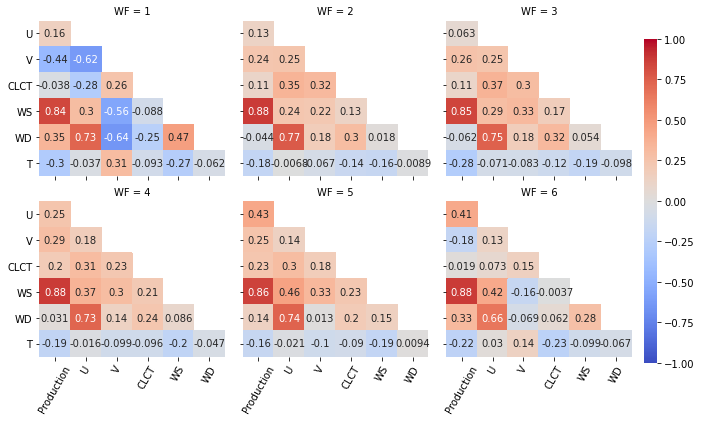

In [53]:
grid = sns.FacetGrid(df_mean, col="WF", col_wrap=3)
cbar_ax = grid.fig.add_axes([1.0, 0.15, 0.02, 0.75])
grid.map_dataframe(unit_wf_corr_graph)
for axes in grid.axes.flat:
    plt.setp(axes.xaxis.get_majorticklabels(), rotation=60)
plt.show()

## Data normalisation

In [56]:
def normalize_data(df):
    """ Normalize features according to their types """
    nwp_cols = [col for col in df.columns if col.startswith('NWP')]

    # CLCT variable is a percentage --> divide it by 100
    nwp_cols_clct = [col for col in nwp_cols if 'CLCT' in col]
    df.loc[:, nwp_cols_clct] /= 100

    # Other variables --> centered and normalized
    nwp_cols_no_clct = [col for col in nwp_cols if 'CLCT' not in col]
    data = df.loc[:, nwp_cols_no_clct]
    df.loc[:, nwp_cols_no_clct] = (data - data.mean()) / data.std()
    return df

In [58]:
df_norm = normalize_data(df_aug)
df_norm.loc[51:54]

,WF,Time,Production,NWP1_T,NWP1_U,NWP1_V,NWP2_U,NWP2_V,NWP3_T,NWP3_U,...,NWP4_U,NWP4_V,NWP4_WS,NWP4_WD,NWP2_WS,NWP2_WD,NWP1_WS,NWP1_WD,NWP3_WS,NWP3_WD
ID,,,,,,,,,,,,,,,,,,,,,
51,1,2018-05-03 03:00:00,5.39,0.104608,1.090236,-2.605292,0.897308,-2.241911,-0.126901,0.866248,...,1.402340,-1.677708,1.625315,1.202273,2.281136,1.296109,2.951174,1.348988,2.533490,1.325045
52,1,2018-05-03 04:00:00,5.11,0.073419,0.811998,-2.719346,0.805403,-2.319197,-0.142071,0.695514,...,1.373109,-1.991421,1.989520,1.241887,2.359324,1.315429,3.020749,1.391082,2.373603,1.346927
53,1,2018-05-03 05:00:00,5.03,0.017822,0.516002,-2.816424,0.713497,-2.396484,-0.157241,0.524779,...,1.200467,-2.278935,2.269041,1.290650,2.443698,1.334038,3.091584,1.433523,2.222241,1.370511
54,1,2018-05-03 06:00:00,7.18,-0.007943,0.428712,-2.739337,0.621592,-2.473770,-0.172411,0.354044,...,0.917177,-2.634260,2.633155,1.350245,2.533912,1.351926,2.943324,1.442862,2.080407,1.395888


# Predict

In [80]:
import tensorflow as tf
import mlflow

## Baseline

In [70]:
class ModelWrapper:
    def __init__(self):
        self.model = None
        self.history = None

    def learning_curves(history):
        """ Plots the training and validation error as a function of the number of epochs """
        plt.figure()
        for key in history.history.keys():
            sns.lineplot(x=range(len(history.history[key])), y=history.history[key], label=key)
    
    def predictions_vs_time(time, y_true, y_predict, label, loss):
        """ Plots true (and predicted if provided) production data as function of time """
        plt.figure(figsize=(15, 6))
        sns.lineplot(x=time, y=y_predict, label='y_predict')
        if y_true is not None:
            sns.lineplot(x=time, y=y_true, label='y_true')
        plt.title(label + f" mse={loss:.2f}")
    
    def train(self, x_train, y_train, x_valid=None, y_valid=None):
        """ Starts the procedure of training (train + plot learning curves) """
        self.run(x_train, y_train, x_valid, y_valid)
        learning_curves(self.history)

    def predict(self, t, x, y_true, label):
        """ Use the trained model to predict on provided data x and compare with y_true """
        y_predict = pd.Series(self.model.predict(x).squeeze(), index=t.index, name="Production")
        loss = np.mean((y_true - y_predict) ** 2)
        predictions_vs_time(t, y_true, y_predict, label, loss)
        return y_predict, loss

In [71]:
class BaselineModel(ModelWrapper) :
    def __init__(self):
        ModelWrapper.__init__(self)
        self.window_size = 1
    
    def run(self, x_train, y_train, x_valid, y_valid):
        # Make windowed datasets
        dataset_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
        dataset_train = dataset_train.shuffle(buffer_size=1024).batch(64)
        dataset_valid = None
        if x_valid is not None and y_valid is not None:
            dataset_valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
            dataset_valid = dataset_valid.batch(64)

        # Define model
        self.model = Sequential([
                    tf.keras.layers.InputLayer(input_shape=next(iter(dataset_train))[0].shape[1:]),
                    tf.keras.layers.Dense(1, activation='relu')
                ])

        # Compile model
        self.model.compile(loss='mse', 
                      optimizer=tf.keras.optimizers.Adam())

        # Train model
        self.history = self.model.fit(dataset_train, 
                                      validation_data=dataset_valid,
                                      epochs=100,
                                      verbose=2)

## RNN model

In [75]:
class RNNModel(ModelWrapper) :
    def __init__(self):
        ModelWrapper.__init__(self)
        self.window_size = 72
    
    def run(self, x_train, y_train, x_valid, y_valid):

        # Make windowed datasets
        dataset_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
        dataset_train = dataset_train.shuffle(buffer_size=1024).batch(64)
        dataset_valid = None
        if x_valid is not None and y_valid is not None:
            dataset_valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))
            dataset_valid = dataset_valid.batch(64)

        # Define model
        self.model = tf.keras.Sequential([
                tf.keras.layers.InputLayer(input_shape=next(iter(dataset_train))[0].shape[1:]),
                tf.keras.layers.GRU(32, return_sequences=True),
                tf.keras.layers.Dropout(0.6),
                tf.keras.layers.GRU(32, return_sequences=True),
                tf.keras.layers.Dropout(0.6),
                tf.keras.layers.GRU(32),
                tf.keras.layers.Dense(1, activation='relu')
                ])

        # Compile model
        self.model.compile(loss='mse', 
                      optimizer=tf.keras.optimizers.Adam())

        # Train model
        self.history = self.model.fit(dataset_train, 
                                      validation_data=dataset_valid,
                                      epochs=100,
                                      verbose=1)
    